<a href="https://colab.research.google.com/github/MadimetjaMadix/action-recognition-vowels/blob/main/Vowels_Action_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import and Install dependencies**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394.3 MB 13 kB/s 
     |████████████████████████████████| 394.3 MB 16 kB/s 
     |████████████████████████████████| 32.8 MB 1.3 MB/s 
     |████████████████████████████████| 3.8 MB 50.0 MB/s 
     |████████████████████████████████| 462 kB 70.5 MB/s 
     |████████████████████████████████| 2.9 MB 55.0 MB/s 
     |████████████████████████████████| 132 kB 78.7 MB/s 
     |████████████████████████████████| 14.8 MB 51.9 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68710 sha256=6721a12a08d8a767f4b5bfdec701e1140a46e05babc512ff8599d31513f13322
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
   

In [1]:
import cv2
import numpy as np
import os
import time
import mediapipe as mp
from matplotlib import pyplot as plt

## Keypoints using MP Holistic


In [2]:
mp_holistic = mp.solutions.holistic #holistic model
mp_drawing = mp.solutions.drawing_utils #drawing utilities

In [3]:
def mediapipe_detection(image, model):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Color conversion BGR -> RGB
  image.flags.writeable = False                   # disable Image writeable
  results = model.process(image)                  # Make Holistic Predictions
  image.flags.writeable = True                    # enable Image Writeable
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Color conversion RGB -> BGR
  return image, results

In [4]:
def draw_landmarks(image, results):
  mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)       # Draw face Connections
  mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)        # Draw pose Connections
  mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)   # Draw left hand Connections
  mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)  # Draw right hand Connections

In [8]:
vid_path = '/content/drive/My Drive/SASL_Vowels/A/A_1.mp4'
cap = cv2.VideoCapture(vid_path)
last_fr = None
last_res = None

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.1, min_tracking_confidence=0.5) as holistic:
  # process the video
  while cap.isOpened():

    # read frame
    ret, frame = cap.read()

    # break if there are no frames to be read
    if not ret:
          break
    
    # make detections
    image, results = mediapipe_detection(frame, holistic)
    if results.right_hand_landmarks:
      #print(results.right_hand_landmarks)
      #cv2_imshow( frame)
      last_fr = frame
      last_res = results

    # live web cam
      #draw_landmarks(image, results)
      #cv2_imshow(image)

    # breake if i say so
    if cv2.waitKey(10) and 0xff == ord('q'):
      break
  cv2.destroyAllWindows()
  cap.release()


Test to see the landmarks

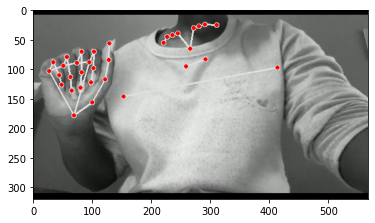

In [9]:
draw_landmarks(last_fr, last_res)
plt.imshow(cv2.cvtColor(last_fr, cv2.COLOR_BGR2RGB))

## **Extracting Keypoint Values**

In [ ]:
def extract_keypoints(results):
  hand_kp = 21*3    # number of hand key points 63
  pose_kp = 33*4    # number of pose key points 132
  face_kp = 468*3    # number of face key points 1404

  face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(face_kp)
  pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(pose_kp)
  l_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(hand_kp)
  r_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(hand_kp)

  #focus on pose and r_hand for now
  # else return np.concatenate([pose, face, l_hand, r_hand])

  return np.concatenate([pose, r_hand]) # 63 + 132 = 195 values


In [ ]:
len(extract_keypoints(results))

195

## **Data Folders**

In [10]:
core_dir = '/content/drive/My Drive'
videos_src = '/content/drive/My Drive/SASL_Vowels'
folder_name = 'Vowels_Data'
data_path = os.path.join(core_dir,folder_name)

#Vowels Folders
vowels = np.array(['A', 'E', 'I', 'O', 'U'])

# no of videos ?? at least 50 valid videos
num_frames = 50



Data Extraction

In [ ]:

def key_value_extractor(vid_path, output_path):
  
  cap = cv2.VideoCapture(vid_path)
  frame_count = 0
  # Set mediapipe model
  with mp_holistic.Holistic(min_detection_confidence=0.1, min_tracking_confidence=0.5) as holistic:
    # process the video
    while cap.isOpened():

      # read frame
      ret, frame = cap.read()

      # break if there are no frames to be read
      if not ret:
            break
      
      # make detections
      image, results = mediapipe_detection(frame, holistic)
      keypoints = extract_keypoints(results)
      npy_path = os.path.join(output_path, str(frame_count))
      np.save(npy_path, keypoints)

      frame_count = frame_count + 1
      # live web cam
        #draw_landmarks(image, results)
        #cv2_imshow(image)

      # breake if i say so
      if cv2.waitKey(10) and 0xff == ord('q'):
        break
    cv2.destroyAllWindows()
    cap.release()

In [ ]:
# For each Vowel
for vowel_folder in os.listdir(videos_src):
  folder_path = os.path.join(videos_src,vowel_folder)
  for vid in os.listdir(folder_path):
    video_file = os.path.join(folder_path,vid)
    vid_data_folder = os.path.join(data_path,vowel_folder,os.path.splitext(vid)[0])
    try:
      # make a folder if its not there
      os.makedirs(vid_data_folder)
    except:
      pass
    
    # key_value_extractor(video_file, vid_data_folder)    # Done

In [ ]:
vid_count = [ {vowel_folder: len(os.path.join(videos_src,vowel_folder))} for vowel_folder in os.listdir(videos_src) ]
vid_count

[{'A': 37}, {'E': 37}, {'I': 37}, {'O': 37}, {'U': 37}]

## **Data Preparation**

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [12]:
# 5 Vowels
# 37 videos each
# frames >50

label_map = {lable: num for num, lable in enumerate(vowels)} # A dictinary
label_map

{'A': 0, 'E': 1, 'I': 2, 'O': 3, 'U': 4}

# Load the data

In [13]:

num_videos = 37
num_frames = 50
sequences = []
labels = []

for folder in os.listdir(data_path):
  print(folder)
  vid_num = 0
  seq_path = os.path.join(data_path,folder)
  for seq_data in os.listdir(seq_path):
    if vid_num == num_videos:
      break
    vid_num = vid_num + 1
    
    window = []
    frame_num = 0
    seq_data_path = os.path.join(seq_path,seq_data)
    for data_file in os.listdir(seq_data_path):
      if frame_num == num_frames:
        break
      res = np.load(os.path.join(seq_data_path,data_file))
      window.append(res)
      frame_num = frame_num + 1
    sequences.append(window)
    labels.append(label_map[folder])


A
E
I
O
U


Change data to np array and y data to categorical data

In [14]:
np.array(sequences).shape

(185, 50, 195)

In [15]:
np.array(labels).shape

(185,)

In [16]:
x = np.array(sequences)

In [17]:
x.shape

(185, 50, 195)

In [18]:
y = to_categorical(labels).astype(int)

In [19]:
y.shape

(185, 5)

# Train-Test Split The data

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

In [21]:
x_train.shape

(148, 50, 195)

## **Build and Train LSTM NN**

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [23]:
vowels.shape[0]

5

In [24]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(50,195)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(vowels.shape[0], activation='softmax'))

In [27]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', 'acc'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 64)            66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 221,189
Trainable params: 221,189
Non-trainable params: 0
__________________________________________________

In [29]:
hist = model.fit(x_train,y_train, epochs=500, validation_data = (x_test, y_test ))

Epoch 1/500
5/5 [==============================] - 11s 815ms/step - loss: 1.9731 - categorical_accuracy: 0.1911 - acc: 0.1911 - val_loss: 1.6230 - val_categorical_accuracy: 0.2162 - val_acc: 0.2162
Epoch 2/500
5/5 [==============================] - 2s 397ms/step - loss: 2.0046 - categorical_accuracy: 0.2153 - acc: 0.2153 - val_loss: 1.5740 - val_categorical_accuracy: 0.2703 - val_acc: 0.2703
Epoch 3/500
5/5 [==============================] - 2s 456ms/step - loss: 1.7749 - categorical_accuracy: 0.2192 - acc: 0.2192 - val_loss: 1.9079 - val_categorical_accuracy: 0.1351 - val_acc: 0.1351
Epoch 4/500
5/5 [==============================] - 2s 495ms/step - loss: 1.6733 - categorical_accuracy: 0.2305 - acc: 0.2305 - val_loss: 1.6126 - val_categorical_accuracy: 0.2162 - val_acc: 0.2162
Epoch 5/500
5/5 [==============================] - 3s 550ms/step - loss: 1.6403 - categorical_accuracy: 0.1797 - acc: 0.1797 - val_loss: 1.6022 - val_categorical_accuracy: 0.1892 - val_acc: 0.1892
Epoch 6/500
5/

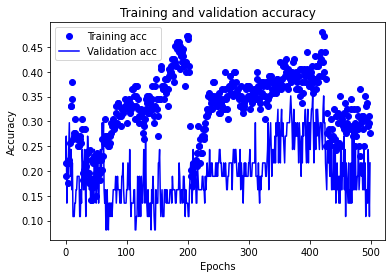

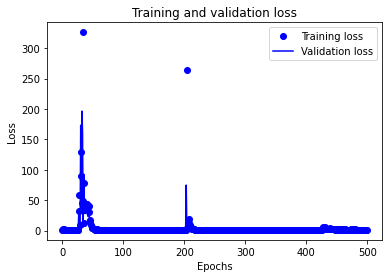

In [30]:
import matplotlib.pyplot as plt

acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()